In [1]:
import s3fs

import os
import json
import time
import pickle
import requests
import time
from datetime import datetime
import warnings
# Ignore warnings from scikit-learn to make this notebook a bit nicer
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

import pandas as pd
from pandas import DataFrame
from pandas import plotting
from pandas.plotting import radviz
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from tqdm.autonotebook import tqdm
tqdm.pandas(desc="progress-bar", leave=False)
import string

import unicodedata  # might need to pip install unicodedate2 on aws sagemaker
import contractions
from contractions import contractions_dict ## pip installed this
from wordcloud import WordCloud, STOPWORDS #pip install
from textblob import TextBlob
!python -m textblob.download_corpora

import nltk
import nltk.corpus 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import word2vec
import multiprocessing as mp

import sklearn
from sklearn.utils import resample # Covert too much Rock! to just enough
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2',rc={'figure.figsize':(9,6),'figure.dpi':90})

# Increase screen size.
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 10000)

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2', rc={'figure.figsize':(9,6), 'figure.dpi':100})
# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot
from yellowbrick.target import ClassBalance

#Pipeline toolset
# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

#Model toolset
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

#Evaluation toolset
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances

[nltk_data] Downloading package brown to /Users/Gretzky/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Gretzky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Gretzky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [2]:
import io
import boto3

from dotenv import load_dotenv
load_dotenv(verbose=True)

def aws_session(region_name='us-east-1'):
    return boto3.session.Session(aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'), #looks for any .env file
                                aws_secret_access_key=os.getenv('AWS_ACCESS_KEY_SECRET'), #Has to be in same directory
                                region_name=region_name) #from above

def make_bucket(name, acl): 
    session = aws_session()
    s3_resource = session.resource('s3')
    return s3_resource.create_bucket(Bucket=name, ACL=acl)

def upload_file_to_bucket(bucket_name, file_path):
    session = aws_session()
    s3_resource = session.resource('s3')
    file_dir, file_name = os.path.split(file_path)

    bucket = s3_resource.Bucket(bucket_name)
    bucket.upload_file(
      Filename=file_path,
      Key=file_name,
      ExtraArgs={'ACL': 'private'}
    )

    s3_url = f"https://{bucket_name}.s3.amazonaws.com/{file_name}"
    return s3_url

fs = s3fs.S3FileSystem(anon=False,key='###',secret='###')


In [3]:
!pwd

/Users/Gretzky/Desktop/DS@GT/Capstone_2/Music-Lyrics/notebooks


In [4]:
#Pulling from local vice AWS as I'm about to go over my free tier usage.
g_df = pd.read_csv('../../g2_df')

In [5]:
#Drop first, useless column.  WHY does this keep coming back?
g_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [6]:
g_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86290 entries, 0 to 86289
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   genre                   86290 non-null  object 
 1   song_name               86290 non-null  object 
 2   lyrics                  86290 non-null  object 
 3   full_word_count         86290 non-null  int64  
 4   full_character_count    86290 non-null  int64  
 5   full_avg_word_length    86290 non-null  float64
 6   med_lyrics              86290 non-null  object 
 7   med_word_count          86290 non-null  int64  
 8   med_character_count     86290 non-null  int64  
 9   med_avg_word_length     86290 non-null  float64
 10  med_content_affin       86290 non-null  float64
 11  med_sent_label          86290 non-null  object 
 12  med_sent_score          86290 non-null  float64
 13  med_vector              86290 non-null  object 
 14  med_rock_genre_count    86290 non-null

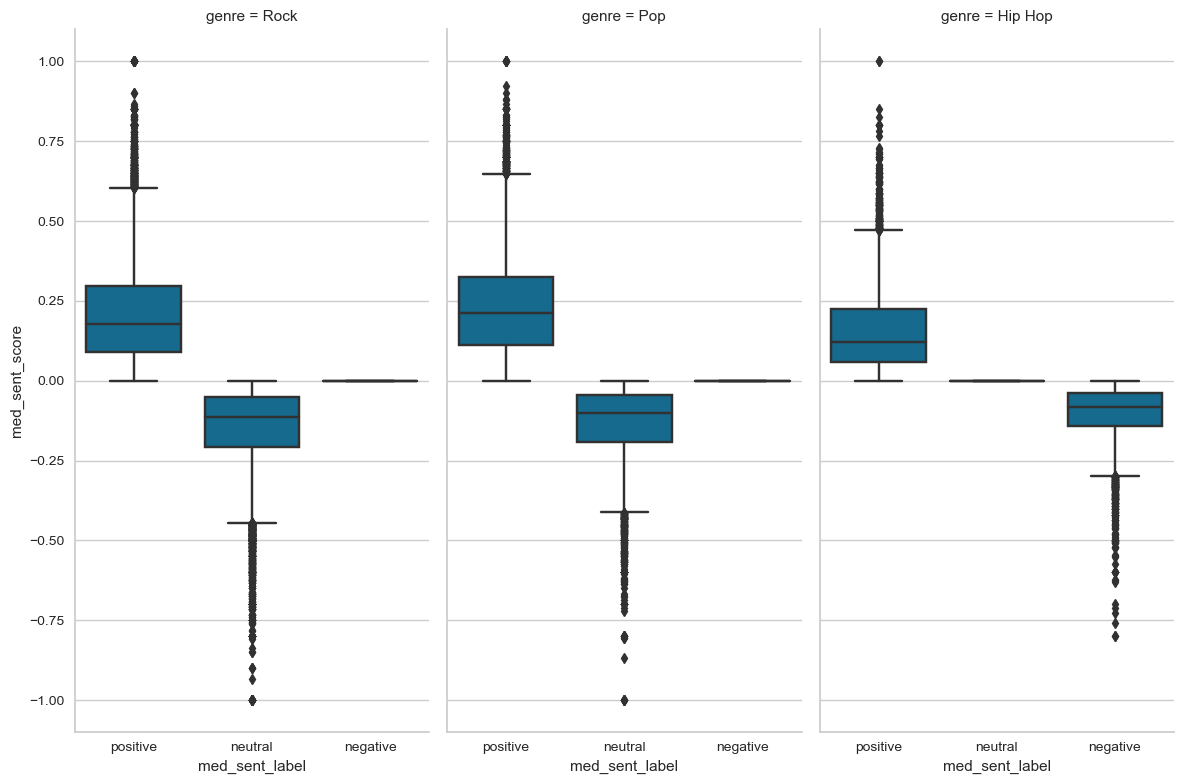

In [7]:
g = sns.FacetGrid(g_df, col ='genre', height=8, aspect=.5)
g = g.map(sns.boxplot, 'med_sent_label', 'med_sent_score')

#There is an issue with showing the negative label distibution in neutral.  EDA shows it's in sns.

In [8]:
g_df.describe(include='all')

,genre,song_name,lyrics,full_word_count,full_character_count,full_avg_word_length,med_lyrics,med_word_count,med_character_count,med_avg_word_length,med_content_affin,med_sent_label,med_sent_score,med_vector,med_rock_genre_count,med_rock_bool,med_hiphop_genre_count,med_hiphop_bool,med_pop_genre_count,med_pop_bool,med_genre_count,sml_lyrics,sml_word_count,sml_character_count,sml_avg_word_length,sml_content_affin,sml_sent_label,sml_sent_score,sml_vector,sml_rock_genre_count,sml_rock_bool,sml_hiphop_genre_count,sml_hiphop_bool,sml_pop_genre_count,sml_pop_bool,sml_genre_count
count,86290,86290,86290,86290.000000,86290.000000,86290.000000,86290,86290.000000,86290.000000,86290.000000,86290.000000,86290,86290.000000,86290,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290,86290.000000,86290.000000,86290.000000,86290.000000,86290,86290.000000,86290,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000
unique,3,66799,86203,NaN,NaN,NaN,85378,NaN,NaN,NaN,NaN,3,NaN,85355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85286,NaN,NaN,NaN,NaN,3,NaN,85264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Rock,Intro,so so you think you can tell heaven from hel...,NaN,NaN,NaN,dreaming white christmas like ones know treeto...,NaN,NaN,NaN,NaN,positive,NaN,dreaming white christmas like one know treetop...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,merry little christmas let heart light trouble...,NaN,NaN,NaN,NaN,positive,NaN,like beauty queen movie scene said mind mean d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,47406,50,3,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,58208,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,58255,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,355.093638,1067.958303,3.032924,NaN,108.455858,552.463715,5.120146,0.010880,NaN,0.096838,NaN,0.006332,0.224591,91.105574,0.162128,0.358106,0.099977,91.470013,NaN,102.333666,509.263924,5.011926,0.011444,NaN,0.097358,NaN,0.000238,0.010036,5.672731,0.018067,0.014162,0.000568,5.687131
std,NaN,NaN,NaN,218.656149,651.998326,0.300625,NaN,74.646193,379.487446,0.467359,0.046185,NaN,0.213209,NaN,0.021912,0.417315,351.449939,0.368570,3.012329,0.299971,351.424018,NaN,68.819909,338.198070,0.429539,0.048637,NaN,0.213692,NaN,0.006379,0.099676,110.012447,0.133194,0.774038,0.023823,110.014459
min,NaN,NaN,NaN,1.000000,8.000000,0.051852,NaN,1.000000,4.000000,3.000000,-0.493151,NaN,-1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,4.000000,3.000000,-0.503979,NaN,-1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,209.000000,638.000000,2.853833,NaN,61.000000,312.000000,4.812500,-0.012953,NaN,-0.035000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,58.000000,291.000000,4.733333,-0.013661,NaN,-0.034707,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,299.000000,908.000000,3.026846,NaN,88.000000,450.000000,5.083333,0.008451,NaN,0.092857,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,84.000000,421.000000,4.982759,0.009302,NaN,0.093636,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,436.000000,1303.000000,3.206452,NaN,129.000000,661.000000,5.384615,0.032754,NaN,0.234662,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120000,NaN,123.000000,615.000000,5.256850,0.034800,NaN,0.235714,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
g_df.head(100)

,genre,song_name,lyrics,full_word_count,full_character_count,full_avg_word_length,med_lyrics,med_word_count,med_character_count,med_avg_word_length,med_content_affin,med_sent_label,med_sent_score,med_vector,med_rock_genre_count,med_rock_bool,med_hiphop_genre_count,med_hiphop_bool,med_pop_genre_count,med_pop_bool,med_genre_count,sml_lyrics,sml_word_count,sml_character_count,sml_avg_word_length,sml_content_affin,sml_sent_label,sml_sent_score,sml_vector,sml_rock_genre_count,sml_rock_bool,sml_hiphop_genre_count,sml_hiphop_bool,sml_pop_genre_count,sml_pop_bool,sml_genre_count
0,Rock,More Than This,i could feel at the time there was no way of ...,188,577,3.069149,feel time way knowing fallen leaves night blow...,42,202,4.809524,0.041152,positive,0.350000,feel time way knowing fallen leaf night blowin...,0.00,0,0.0,0,0.0,0,0.00,feel time way knowing fallen leaves night blow...,42,202,4.809524,0.041152,positive,0.350000,feel time way knowing fallen leaf night blowin...,0.0,0,0.0,0,0.0,0,0.0
1,Rock,Because The Night,take me now baby here as i am hold me close...,299,970,3.244147,baby hold close try understand desire hunger b...,93,504,5.419355,-0.006711,positive,0.189394,baby hold close try understand desire hunger b...,0.00,0,0.0,0,0.0,0,0.00,baby hold close try understand desire hunger b...,92,497,5.402174,-0.006803,positive,0.189394,baby hold close try understand desire hunger b...,0.0,0,0.0,0,0.0,0,0.0
2,Rock,These Are Days,these are these are days you will remember n...,213,685,3.215962,days remember promise world warm feel know tru...,49,250,5.102041,0.057047,positive,0.383333,day remember promise world warm feel know true...,0.00,0,0.0,0,0.0,0,0.00,days remember promise world warm feel know tru...,48,245,5.104167,0.058219,positive,0.383333,day remember promise world warm feel know true...,0.0,0,0.0,0,0.0,0,0.0
3,Rock,A Campfire Song,a lie to say of my mountain has coal veins a...,336,963,2.866071,lie mountain coal veins beds dig men axes dig ...,95,452,4.757895,-0.027473,negative,-0.138095,lie mountain coal vein bed dig men ax dig lie ...,0.00,0,200.0,1,0.0,0,200.00,lie mountain coal veins beds dig men dig lie s...,87,403,4.632184,-0.030675,negative,-0.138095,lie mountain coal vein bed dig men dig lie ssa...,0.0,0,0.0,0,0.0,0,0.0
4,Rock,Everyday Is Like Sunday,trudging slowly over wet sand back to the ben...,141,506,3.588652,trudging slowly wet sand bench clothes stolen ...,64,353,5.515625,0.009615,negative,-0.018750,trudging slowly wet sand bench clothes stolen ...,0.00,0,0.0,0,0.0,0,0.00,slowly wet sand bench clothes stolen town forg...,59,319,5.406780,0.010610,negative,-0.018750,slowly wet sand bench clothes stolen town forg...,0.0,0,0.0,0,0.0,0,0.0
5,Rock,Don't Talk,do not talk i will listen do not talk you k...,346,1033,2.985549,talk listen talk distance hear truth tonight e...,97,474,4.886598,0.007018,positive,0.087963,talk listen talk distance hear truth tonight e...,0.00,0,0.0,0,0.0,0,0.00,talk listen talk distance hear truth tonight e...,95,459,4.831579,0.007233,positive,0.087963,talk listen talk distance hear truth tonight e...,0.0,0,0.0,0,0.0,0,0.0
6,Rock,Across The Fields,well they left then in the morning a hundred ...,154,498,3.233766,left morning pairs wings light moved colors mo...,42,216,5.142857,0.011673,positive,0.300000,left morning pair wing light moved color morni...,0.03,1,0.0,0,0.0,0,0.03,left morning pairs wings light moved colors mo...,37,185,5.000000,0.013575,positive,0.300000,left morning pair wing light moved color morni...,0.0,0,0.0,0,0.0,0,0.0
7,Rock,Planned Obsolescence,music dennis drew lyric natalie merchant ...,153,586,3.830065,music dennis drew lyric natalie merchant scien...,71,492,6.929577,-0.019573,positive,0.183929,music dennis drew lyric natalie merchant scien...,0.06,1,0.0,0,0.0,0,0.06,music drew lyric natalie science truth life wa...,58,388,6.689655,-0.026966,positive,0.183929,music drew lyric natalie science truth life wa...,0.0,0,0.0,0,0.0,0,0.0
8,Rock,Rainy Day,on bended kneeive look

In [10]:
g_df.groupby(['med_sent_label','genre']).count()

song_name  lyrics  full_word_count  full_character_count  full_avg_word_length  med_lyrics  med_word_count  med_character_count  med_avg_word_length  med_content_affin  med_sent_score  med_vector  med_rock_genre_count  med_rock_bool  med_hiphop_genre_count  med_hiphop_bool  med_pop_genre_count  med_pop_bool  med_genre_count  sml_lyrics  sml_word_count  sml_character_count  sml_avg_word_length  sml_content_affin  sml_sent_label  sml_sent_score  sml_vector  sml_rock_genre_count  sml_rock_bool  sml_hiphop_genre_count  sml_hiphop_bool  sml_pop_genre_count  sml_pop_bool  sml_genre_count
med_sent_label genre                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
negative       Hip Hop       5356    5356             5356                  5356                  5356        5356            5356                 5356                 5356               5356            5356        5356                  5356           5356                    5356             5356                 5356          5356             5356        5356            5356                 5356                 5356               5356            5356            5356        5356                  5356           5356                    5356             5356                 5356          5356             5356
               Pop           5858    5858             5858                  5858                  5858        5858            5858                 5858                 5858               5858            5858        5858                  5858           5858                    5858             5858                 5858          5858             5858        5858            5858                 5858                 5858               5858            5858            5858        5858                  5858           5858                    5858             5858                 5858          5858             5858
               Rock         15421   15421            15421                 15421                 15421       15421           15421                15421                15421              15421           15421       15421                 15421          15421                   15421            15421                15421         15421            15421       15421           15421                15421                15421              15421           15421           15421       15421                 15421          15421                   15421            15421                15421         15421            15421
neutral        Hip Hop         79      79               79                    79                    79          79              79                   79                   79                 79              79          79                    79             79                      79               79                   79            79               79          79              79                   79                   79                 79              79              79          79                    79             79                      79               79                   79            79               79
               Pop            290     290              290                   290                   290         290             290                  290                  290                290             290         290                   290            290                     290              290                  290           290              

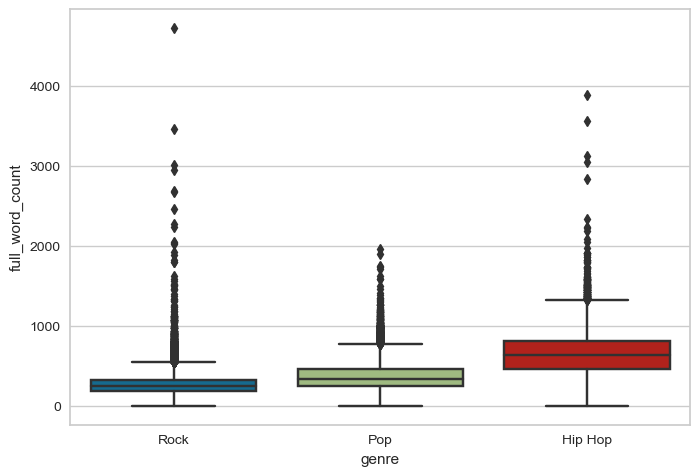

In [11]:
ax = sns.boxplot(x='genre', y='full_word_count', data=g_df)

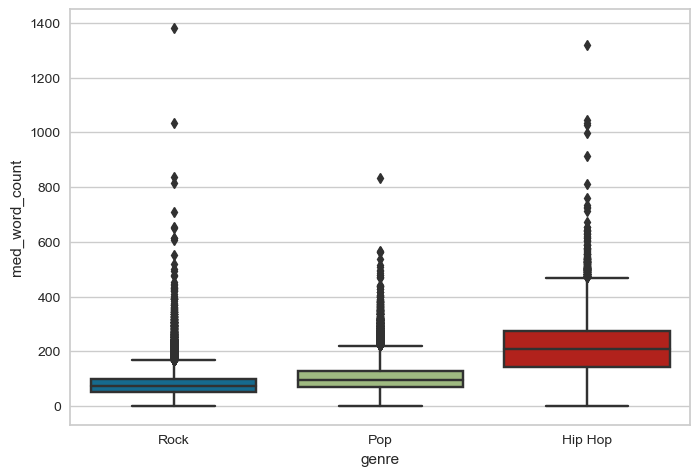

In [12]:
ax = sns.boxplot(x='genre', y='med_word_count', data=g_df)

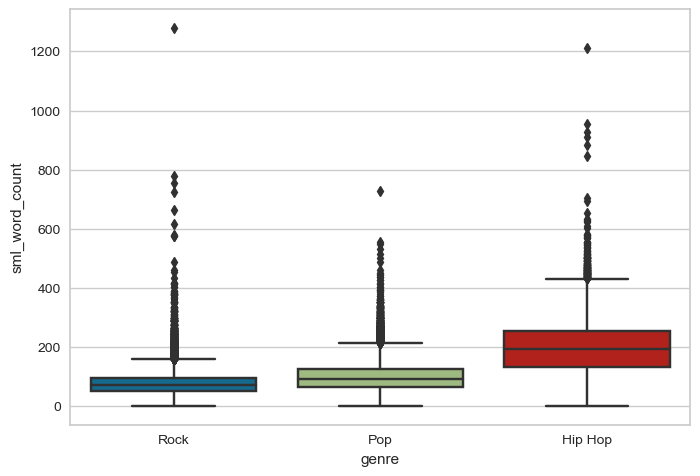

In [13]:
ax = sns.boxplot(x='genre', y='sml_word_count', data=g_df)

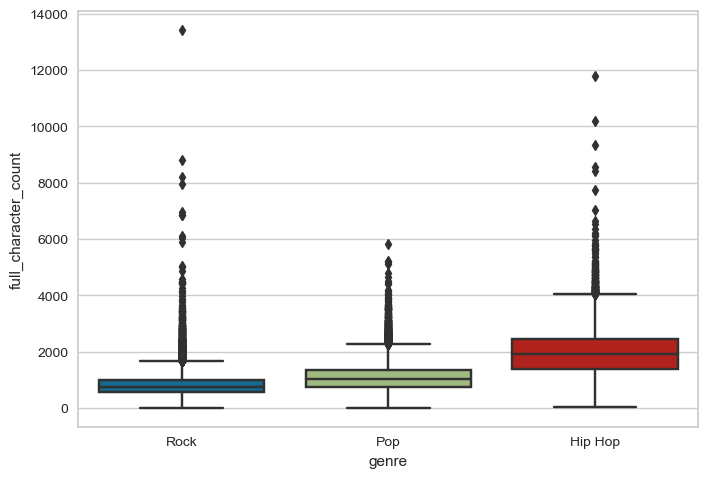

In [14]:
ax = sns.boxplot(x='genre', y='full_character_count', data=g_df)

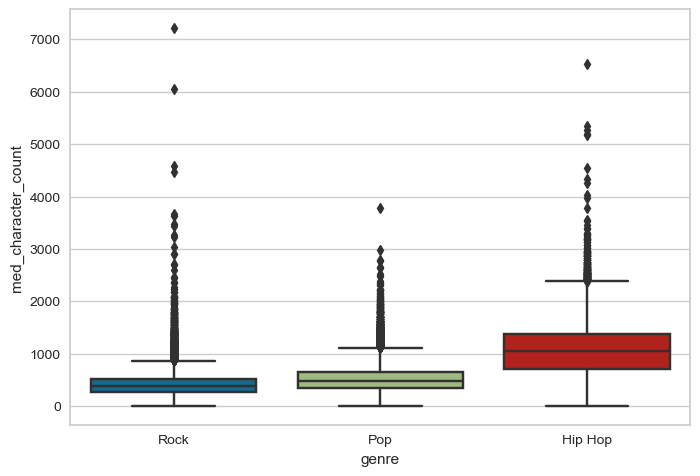

In [15]:
ax = sns.boxplot(x='genre', y='med_character_count', data=g_df)

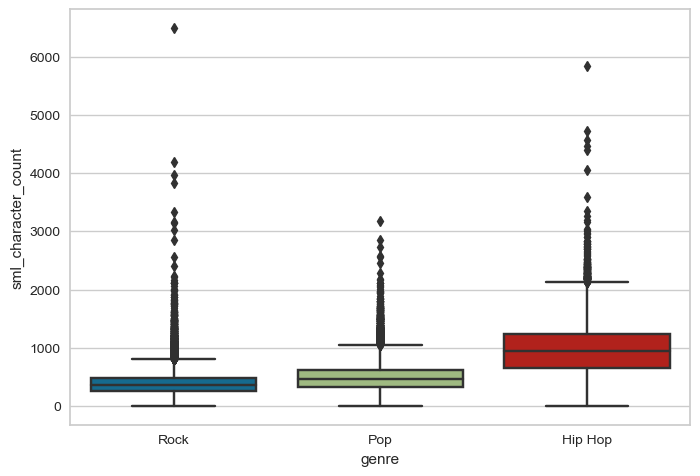

In [16]:
ax = sns.boxplot(x='genre', y='sml_character_count', data=g_df)

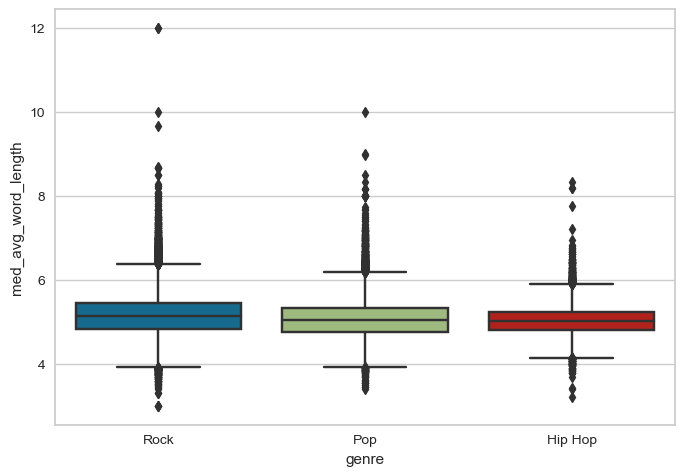

In [17]:
ax = sns.boxplot(x='genre', y='med_avg_word_length', data=g_df)

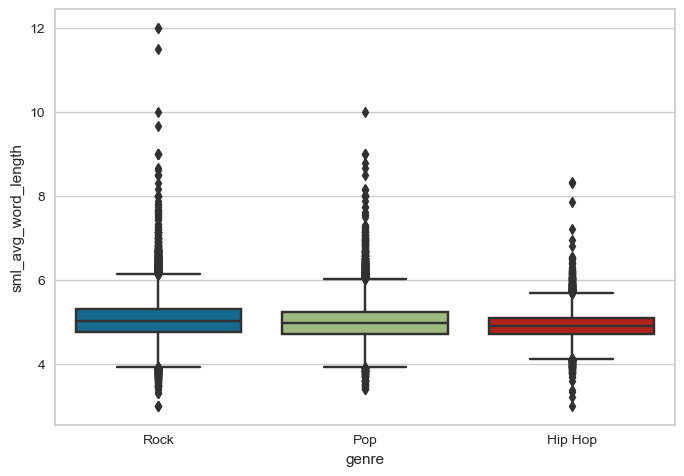

In [18]:
ax = sns.boxplot(x='genre', y='sml_avg_word_length', data=g_df)

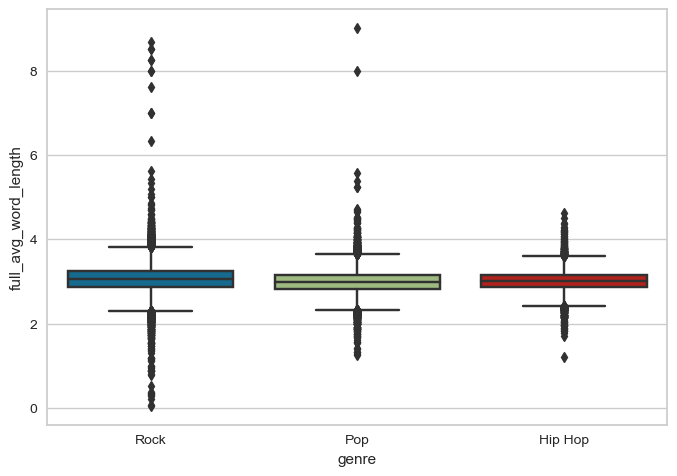

In [19]:
ax = sns.boxplot(x='genre', y='full_avg_word_length', data=g_df)
#Outliers here is a function of not being downsampled yet. 

sml_word_count shows the biggest difference.  Will use this.

[size]_character_count has co-variance with [size]_word_count.

[size]_avg_word_length is same across genres.  Noise.  Won't use.

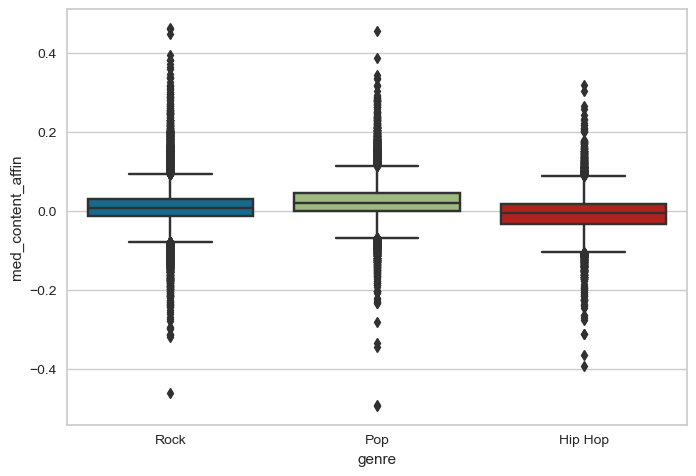

In [20]:
ax = sns.boxplot(x='genre', y='med_content_affin', data=g_df)

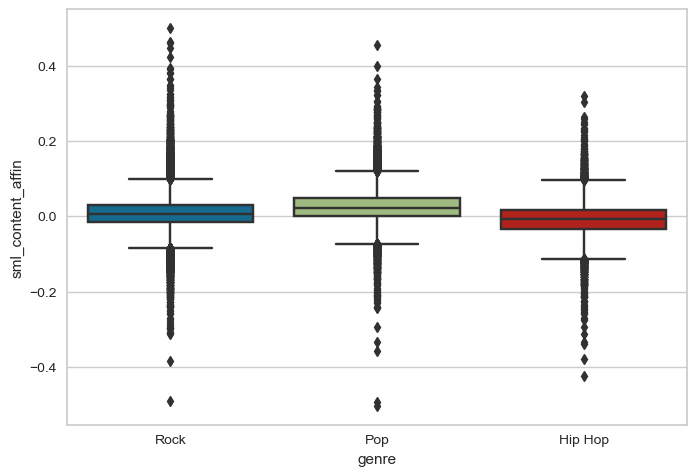

In [21]:
ax = sns.boxplot(x='genre', y='sml_content_affin', data=g_df)

[size]_sent_score very similar.  sml_sent_score has a slightly wider range.  Will use that.

sml_content_affin has bigger mean, std and range.  More variance, means more descriptive.

In [22]:
g_df[g_df == 0].count(axis=0)
#Shows what is a zero.  86290 - this number has a piece of data in that df.iloc

genre                         0
song_name                     0
lyrics                        0
full_word_count               0
full_character_count          0
full_avg_word_length          0
med_lyrics                    0
med_word_count                0
med_character_count           0
med_avg_word_length           0
med_content_affin          2606
med_sent_label                0
med_sent_score             1447
med_vector                    0
med_rock_genre_count      66910
med_rock_bool             66910
med_hiphop_genre_count    72300
med_hiphop_bool           72300
med_pop_genre_count       77663
med_pop_bool              77663
med_genre_count           48541
sml_lyrics                    0
sml_word_count                0
sml_character_count           0
sml_avg_word_length           0
sml_content_affin          2675
sml_sent_label                0
sml_sent_score             1473
sml_vector                    0
sml_rock_genre_count      85424
sml_rock_bool             85424
sml_hiph

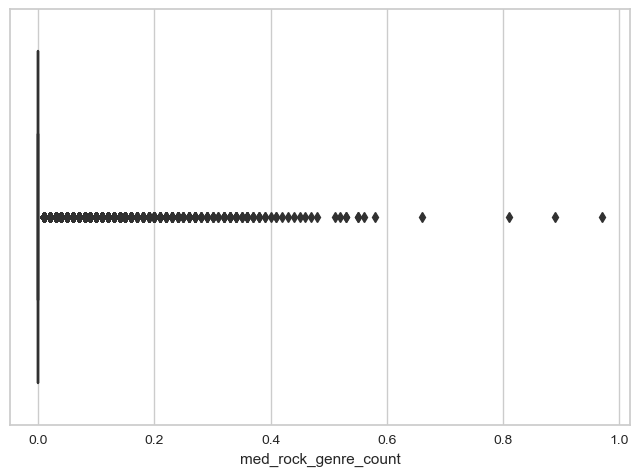

In [23]:
ax = sns.boxplot(x='med_rock_genre_count', data=g_df)

#This is kinda pointless, ~67k are zero.  
#Scale this and it just gets even more washed out.
#Should I go with Boolean (if >0==True)?

#I created the [size]_[genre]_bool feature to get at this idea.

In [24]:
#df for more feature selection type work.  Exclusively numerical features.
#Looking to confirm/deny/tighten up viusal steering and my own biases/heuristics.
#Removed  dtype = object features.
#Removed [size]_genre_count (that was never a good idea).

g2_df = pd.DataFrame((g_df), columns=['genre','full_word_count','full_character_count','full_avg_word_length',
                                      'med_word_count','med_character_count','med_avg_word_length',
                                      'med_content_affin','med_sent_score',
                                      'med_rock_genre_count','med_rock_bool',
                                      'med_hiphop_genre_count','med_hiphop_bool',
                                      'med_pop_genre_count','med_pop_bool',
                                      'sml_word_count','sml_character_count','sml_avg_word_length',
                                      'sml_content_affin','sml_sent_score',
                                      'sml_rock_genre_count','sml_rock_bool',
                                      'sml_hiphop_genre_count','sml_hiphop_bool',
                                      'sml_pop_genre_count','sml_pop_bool'])

In [25]:
g2_df.describe(include='all')

,genre,full_word_count,full_character_count,full_avg_word_length,med_word_count,med_character_count,med_avg_word_length,med_content_affin,med_sent_score,med_rock_genre_count,med_rock_bool,med_hiphop_genre_count,med_hiphop_bool,med_pop_genre_count,med_pop_bool,sml_word_count,sml_character_count,sml_avg_word_length,sml_content_affin,sml_sent_score,sml_rock_genre_count,sml_rock_bool,sml_hiphop_genre_count,sml_hiphop_bool,sml_pop_genre_count,sml_pop_bool
count,86290,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Rock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,47406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,355.093638,1067.958303,3.032924,108.455858,552.463715,5.120146,0.010880,0.096838,0.006332,0.224591,91.105574,0.162128,0.358106,0.099977,102.333666,509.263924,5.011926,0.011444,0.097358,0.000238,0.010036,5.672731,0.018067,0.014162,0.000568
std,NaN,218.656149,651.998326,0.300625,74.646193,379.487446,0.467359,0.046185,0.213209,0.021912,0.417315,351.449939,0.368570,3.012329,0.299971,68.819909,338.198070,0.429539,0.048637,0.213692,0.006379,0.099676,110.012447,0.133194,0.774038,0.023823
min,NaN,1.000000,8.000000,0.051852,1.000000,4.000000,3.000000,-0.493151,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,3.000000,-0.503979,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,209.000000,638.000000,2.853833,61.000000,312.000000,4.812500,-0.012953,-0.035000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58.000000,291.000000,4.733333,-0.013661,-0.034707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,299.000000,908.000000,3.026846,88.000000,450.000000,5.083333,0.008451,0.092857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,84.000000,421.000000,4.982759,0.009302,0.093636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,436.000000,1303.000000,3.206452,129.000000,661.000000,5.384615,0.032754,0.234662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,123.000000,615.000000,5.256850,0.034800,0.235714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
# Scaling the numbers for the various counts and lengths.
# Leaving sent_score, content_affin, genre_bool, and avg_word_length alone.

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

column_to_normalize = ['full_word_count','full_character_count',
                       'med_word_count','med_character_count',
                       'med_rock_genre_count','med_hiphop_genre_count','med_pop_genre_count',
                       'sml_word_count','sml_character_count',
                       'sml_rock_genre_count','sml_hiphop_genre_count','sml_pop_genre_count']

# 'norm'd' df = n_df, which, right now if g_df.copy()
n_df = g2_df.copy()
n2_df = pd.DataFrame((n_df), columns = column_to_normalize)


x = n2_df.values
x_scaled = scaler.fit_transform(x)
df_temp = pd.DataFrame(x_scaled, columns = column_to_normalize, index = n_df.index)

n_df[column_to_normalize] = df_temp

In [27]:
#n_df = 'normalized' which is the wrong word.  Should be s_df for 'scaled' which is what MinMax does.
n_df.describe(include='all')

,genre,full_word_count,full_character_count,full_avg_word_length,med_word_count,med_character_count,med_avg_word_length,med_content_affin,med_sent_score,med_rock_genre_count,med_rock_bool,med_hiphop_genre_count,med_hiphop_bool,med_pop_genre_count,med_pop_bool,sml_word_count,sml_character_count,sml_avg_word_length,sml_content_affin,sml_sent_score,sml_rock_genre_count,sml_rock_bool,sml_hiphop_genre_count,sml_hiphop_bool,sml_pop_genre_count,sml_pop_bool
count,86290,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000,86290.000000
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Rock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,47406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.074988,0.079107,3.032924,0.077923,0.076091,5.120146,0.010880,0.096838,0.006528,0.224591,0.005033,0.162128,0.001818,0.099977,0.079353,0.077949,5.011926,0.011444,0.097358,0.000361,0.010036,0.000320,0.018067,0.000156,0.000568
std,NaN,0.046306,0.048660,0.300625,0.054131,0.052648,0.467359,0.046185,0.213209,0.022590,0.417315,0.019417,0.368570,0.015291,0.299971,0.053892,0.052175,0.429539,0.048637,0.213692,0.009666,0.099676,0.006215,0.133194,0.008506,0.023823
min,NaN,0.000000,0.000000,0.051852,0.000000,0.000000,3.000000,-0.493151,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,-0.503979,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.044049,0.047018,2.853833,0.043510,0.042730,4.812500,-0.012953,-0.035000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044636,0.044276,4.733333,-0.013661,-0.034707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.063109,0.067169,3.026846,0.063089,0.061876,5.083333,0.008451,0.092857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064996,0.064332,4.982759,0.009302,0.093636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,0.092122,0.096649,3.206452,0.092821,0.091149,5.384615,0.032754,0.234662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095536,0.094261,5.256850,0.034800,0.235714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [28]:
#DOWNSAMPLE

seed = 119

#Separate majority and minority classes, twice.
majority = n_df[n_df.genre=='Rock']
minority = n_df[n_df.genre=='Hip Hop']

# Downsample majority class
majority_rock_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

seed = 119

#Separate majority and minority classes, again.
majority = n_df[n_df.genre=='Pop']
minority = n_df[n_df.genre=='Hip Hop']

# Downsample majority class
majority_pop_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

# Combine minority class with downsampled majority class
n_dfd = pd.concat([majority_rock_downsampled, majority_pop_downsampled, minority])

# Display new class counts
n_dfd['genre'].value_counts()
# n_dfd = 'data frame downsampled'

Rock       13560
Pop        13560
Hip Hop    13560
Name: genre, dtype: int64

In [29]:
# Create X and y.  Obviously, your df name may vary...
X = n_dfd.loc[ : , n_dfd.columns != 'genre']
y = n_dfd['genre']

In [30]:
# tts of the numerical-only, scaled, downsampled set.
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(32544, 25) (32544,)
(8136, 25) (8136,)


In [19]:
model = FeatureImportances(
    Lasso(alpha=5.5), relative=False
)

model.fit(X_train, y_train)
model.score(X_test, y_test)
model.show()

#Surprise! Lasso/Ridge are regressions, don't work well for classification problems, without some un-natural 
#one-hot-encoding of target classes.  Maybe if it was binary / boolean.  But three classes would
#confuse the issue.

ValueError: could not convert string to float: 'Rock'

In [31]:
# ANOVA feature selection for numeric input and categorical output

#Next few cells I am learning how to use.  Then I iteratively increase the # of features allowed, and 
#check which features it adds.  I am creating a poor-man's RFECV.

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# define feature selection
fs = SelectKBest(score_func=f_classif, k=7)
# apply feature selection
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(40680, 7)


In [32]:
type(X_selected)

numpy.ndarray

In [33]:
X_selected

array([[0.04489623, 0.0524666 , 0.03843365, ..., 0.        , 0.04072044,
        0.04350509],
       [0.03727234, 0.04537652, 0.03770848, ..., 0.        , 0.03132341,
        0.03563715],
       [0.0343075 , 0.03656989, 0.04278463, ..., 1.        , 0.04306969,
        0.042888  ],
       ...,
       [0.17767895, 0.16949026, 0.20884699, ..., 1.        , 0.21848081,
        0.20055538],
       [0.11245235, 0.11978506, 0.14140682, ..., 1.        , 0.13469068,
        0.13637766],
       [0.0167302 , 0.01604597, 0.01667875, ..., 1.        , 0.01644479,
        0.01511879]])

In [34]:
X_selected = fs.get_params(deep=True)
print(X_selected)

{'k': 7, 'score_func': <function f_classif at 0x7feab1c454c0>}


In [35]:
X_selected = fs.get_support(indices=False)
print(X_selected)

[ True  True False  True  True False False False False False False  True
 False False  True  True False False False False False False False False
 False]


In [36]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

anova_filter = SelectKBest(f_classif, k=25)
clf = LinearSVC()
anova_svm = make_pipeline(anova_filter, clf)

anova_svm.fit(X_train, y_train)

Pipeline(steps=[('selectkbest', SelectKBest(k=25)), ('linearsvc', LinearSVC())])

In [37]:
from sklearn.metrics import classification_report

y_pred = anova_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Hip Hop       0.90      0.79      0.84      2755
         Pop       0.63      0.70      0.67      2662
        Rock       0.71      0.73      0.72      2719

    accuracy                           0.74      8136
   macro avg       0.75      0.74      0.74      8136
weighted avg       0.75      0.74      0.74      8136



Performed a poor-man's recursive feature elimnination.  K=3,5,7,10,15,20,25.  Looking at combined (rock, pop, hiphop) F1 score, the knee in the curve is 10.  X_train columns 4,12,15,5,16,1,2,10,11,14.  Pretty much in that order.

In [38]:
#Same drill, KNeighbors. Looked at n=3, 5, 7.  Looked at k=3, 5, 7, 10, 15, 20, 25.  
#Confirmed rank importance, whiich was silly as the f_classf() is a mask.  It will always pass the 
#same features in the same order regardless of 'clf'.

anova_filter = SelectKBest(f_classif, k=25)
clf = KNeighborsClassifier(n_neighbors=7)
anova_svm = make_pipeline(anova_filter, clf)

anova_svm.fit(X_train, y_train)

y_pred = anova_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Hip Hop       0.86      0.81      0.83      2755
         Pop       0.60      0.67      0.63      2662
        Rock       0.69      0.65      0.67      2719

    accuracy                           0.71      8136
   macro avg       0.72      0.71      0.71      8136
weighted avg       0.72      0.71      0.71      8136



In [39]:
#Same drill, RandomForestClassifier(). Looked at k=3, 5, 7, 10, 15, 20, 25.

anova_filter = SelectKBest(f_classif, k=10)
clf = RandomForestClassifier()
anova_svm = make_pipeline(anova_filter, clf)

anova_svm.fit(X_train, y_train)

y_pred = anova_svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Hip Hop       0.87      0.81      0.84      2755
         Pop       0.63      0.65      0.63      2662
        Rock       0.68      0.71      0.70      2719

    accuracy                           0.72      8136
   macro avg       0.73      0.72      0.72      8136
weighted avg       0.73      0.72      0.73      8136



In [40]:
X_selected = fs.get_support(indices=False)
print(X_selected)

[ True  True False  True  True False False False False False False  True
 False False  True  True False False False False False False False False
 False]


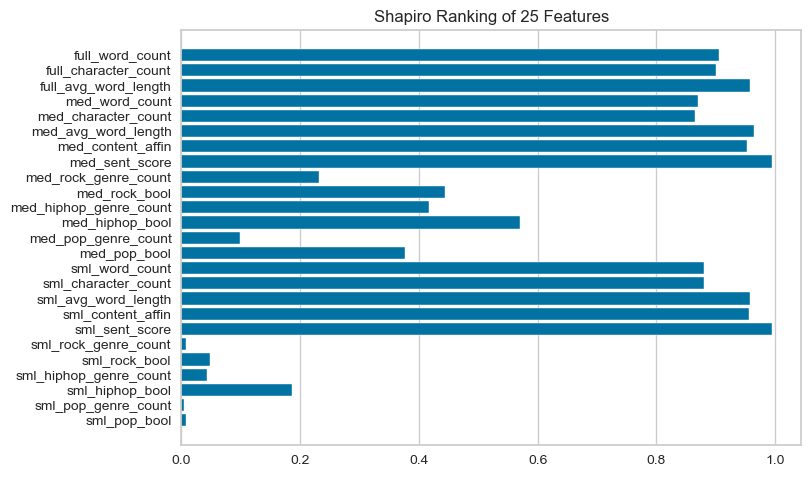

<AxesSubplot:title={'center':'Shapiro Ranking of 25 Features'}>

In [41]:
from yellowbrick.features import Rank1D

visualizer = Rank1D(alogorithm='shapiro')

visualizer.fit(X,y)
visualizer.transform(X)
visualizer.show()

Unlike with ANOVA, this shows sentiment and affinity as very important. ANOVA did not pick them less than 11th.


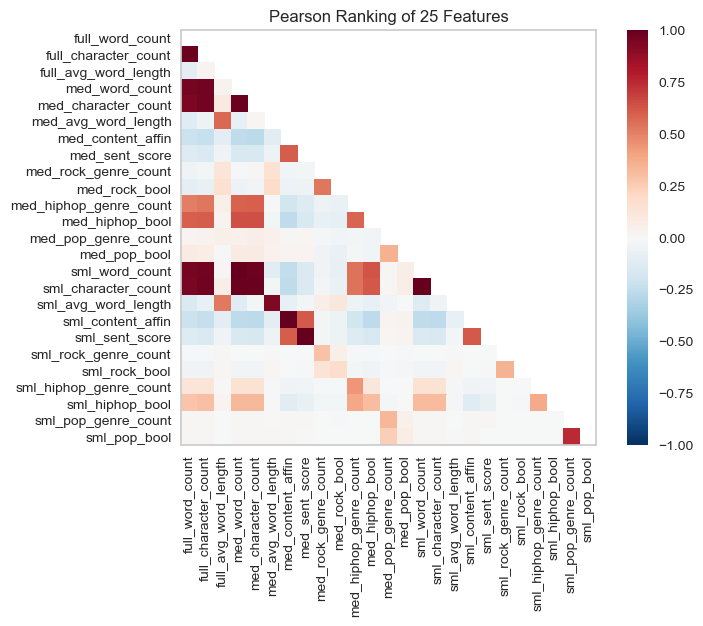

<AxesSubplot:title={'center':'Pearson Ranking of 25 Features'}>

In [42]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(alogorithm='pearson')

visualizer.fit(X,y)
visualizer.transform(X)
visualizer.show()

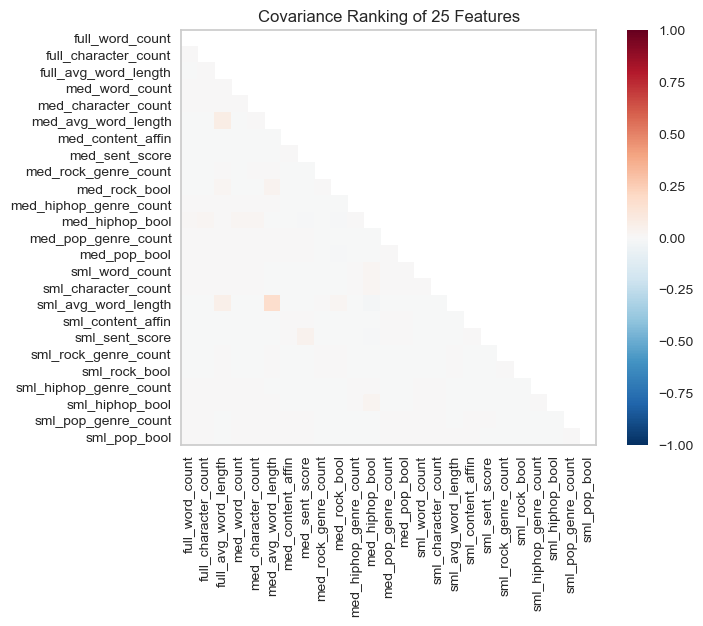

<AxesSubplot:title={'center':'Covariance Ranking of 25 Features'}>

In [43]:
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm='covariance')

visualizer.fit(X,y)
visualizer.transform(X)
visualizer.show()

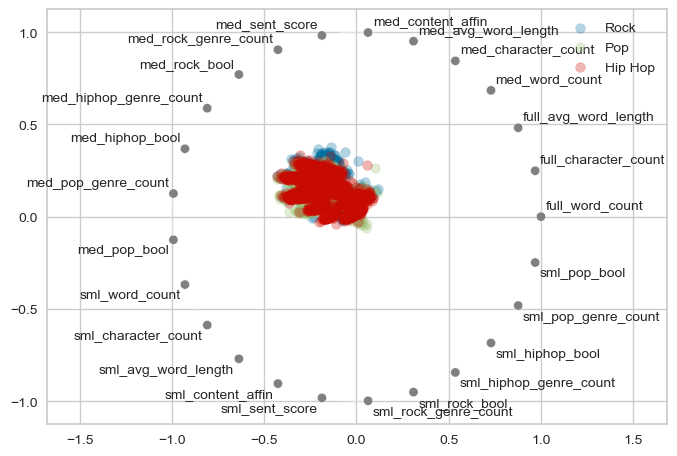

In [44]:
#A visual look at all of the numerical features, mostly scaled (except affin and sentiment).  One big blob.

from pandas.plotting import radviz

def rad_viz(df,labels):
    fig = radviz(df, labels, color=sns.color_palette(), alpha=.3)
    plt.show()


rad_viz(n_dfd,'genre')

In [45]:
#Ran this with KNN and Linear SVC.  Generally recommended more features than ANOVA did.  Going from
# 10 feature (ANOVA knee-in-the-curve) to 15 made a ~.05 point difference to f-score in RFECV

from sklearn.feature_selection import RFECV

estimator = LinearSVC()
selector = RFECV(estimator, step=1, cv=10)
selector = selector.fit(X, y)

In [46]:
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 18


In [47]:
selector.support_

array([ True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True, False,  True, False, False])

In [48]:
selector.ranking_

array([1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 8, 1, 6,
       1, 4, 5])

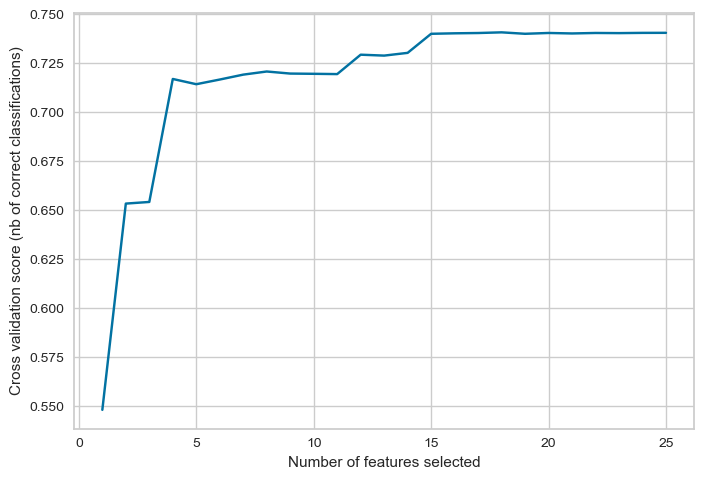

In [49]:
min_features_to_select = 1

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(selector.grid_scores_) + min_features_to_select),
         selector.grid_scores_)
plt.show()

In [50]:
estimator = RandomForestClassifier()
selector = RFECV(estimator, step=1, cv=10)
selector = selector.fit(X, y)

print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 17


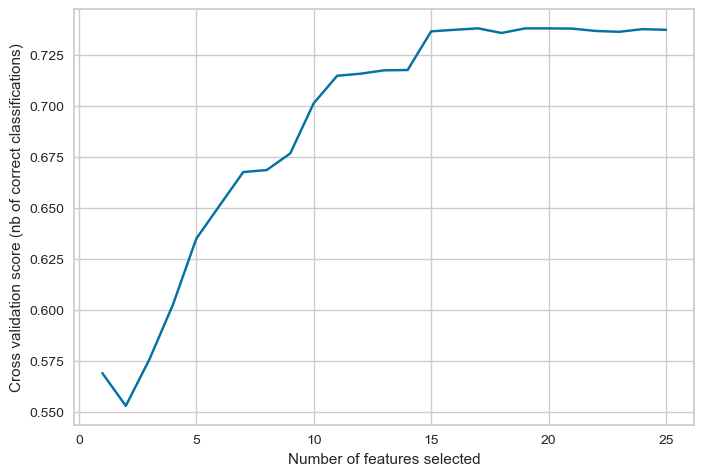

In [51]:
min_features_to_select = 1

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(selector.grid_scores_) + min_features_to_select),
         selector.grid_scores_)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


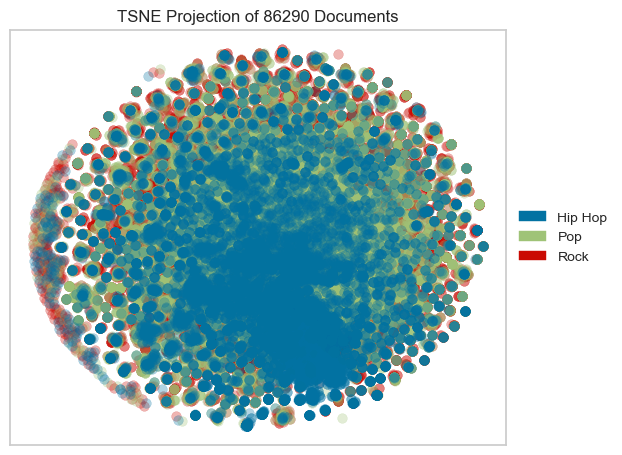

Current Time med_vector, 
 min_df=1500, 
 decompose=1000 = 2021-06-29 10:58:57.428576


In [54]:
# Increase screen size.
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1500)

from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=500)
text_tfidf = vectorizer.fit_transform(g_df['med_vector'])
color = g_df['genre']

tsne = TSNEVisualizer(decompose_by=1000, alpha=.3)
tsne.fit(text_tfidf, g_df['genre'])
tsne.poof()

print("Current Time med_vector, \n min_df=1500, \n decompose=1000 =", datetime.now())

In [55]:
# Went from g_df (35 features) to df (25 numerical features) to n_df (25 scaled, numerical features).
#Dataset recommended by ANNOVA feature selection:

g3_df = pd.DataFrame((n_df), columns=['genre','full_word_count','full_character_count',
                                      'med_word_count','med_character_count',
                                      'med_rock_bool',
                                      'med_hiphop_genre_count','med_hiphop_bool',
                                      'med_pop_bool',
                                      'sml_word_count','sml_character_count'])

In [56]:
seed = 119

#Separate majority and minority classes, twice.
majority = g3_df[g3_df.genre=='Rock']
minority = g3_df[g3_df.genre=='Hip Hop']

# Downsample majority class
majority_rock_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

seed = 119

#Separate majority and minority classes, again.
majority = g3_df[g3_df.genre=='Pop']
minority = g3_df[g3_df.genre=='Hip Hop']

# Downsample majority class
majority_pop_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

# Combine minority class with downsampled majority class
g3_dfd = pd.concat([majority_rock_downsampled, majority_pop_downsampled, minority])

# Display new class counts
g3_dfd['genre'].value_counts()
# g3_dfd = 'data frame downsampled'

Rock       13560
Pop        13560
Hip Hop    13560
Name: genre, dtype: int64

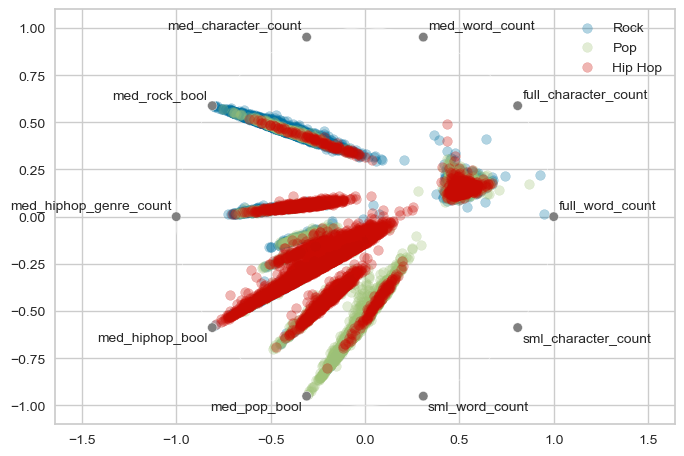

In [57]:
# Visual look at the numerical features post feature selection.

rad_viz(g3_dfd,'genre')

In [58]:
n_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86290 entries, 0 to 86289
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   genre                   86290 non-null  object 
 1   full_word_count         86290 non-null  float64
 2   full_character_count    86290 non-null  float64
 3   full_avg_word_length    86290 non-null  float64
 4   med_word_count          86290 non-null  float64
 5   med_character_count     86290 non-null  float64
 6   med_avg_word_length     86290 non-null  float64
 7   med_content_affin       86290 non-null  float64
 8   med_sent_score          86290 non-null  float64
 9   med_rock_genre_count    86290 non-null  float64
 10  med_rock_bool           86290 non-null  int64  
 11  med_hiphop_genre_count  86290 non-null  float64
 12  med_hiphop_bool         86290 non-null  int64  
 13  med_pop_genre_count     86290 non-null  float64
 14  med_pop_bool            86290 non-null

In [59]:
# Went from g_df (35 features) to df (25 numerical features) to n_df (25 scaled, numerical features).
#I think having both halves of [size]_word/character_count is colinearity risk.
#I think [size]_content_affin and [size]_sent_score are meaningful.
#Dataset recommended by Pearson and my-own-biases feature selection:

g4_df = pd.DataFrame((n_df), columns=['genre','full_word_count','full_character_count',
                                      'med_word_count','med_character_count',
                                      'med_rock_bool',
                                      'med_hiphop_genre_count','med_hiphop_bool',
                                      'med_pop_bool',
                                      'sml_content_affin','sml_sent_score'])

In [60]:
seed = 119

#Separate majority and minority classes, twice.
majority = g4_df[g4_df.genre=='Rock']
minority = g4_df[g4_df.genre=='Hip Hop']

# Downsample majority class
majority_rock_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

seed = 119

#Separate majority and minority classes, again.
majority = g4_df[g4_df.genre=='Pop']
minority = g4_df[g4_df.genre=='Hip Hop']

# Downsample majority class
majority_pop_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

# Combine minority class with downsampled majority class
g4_dfd = pd.concat([majority_rock_downsampled, majority_pop_downsampled, minority])

# Display new class counts
g4_dfd['genre'].value_counts()
# g4_dfd = 'data frame downsampled'

Rock       13560
Pop        13560
Hip Hop    13560
Name: genre, dtype: int64

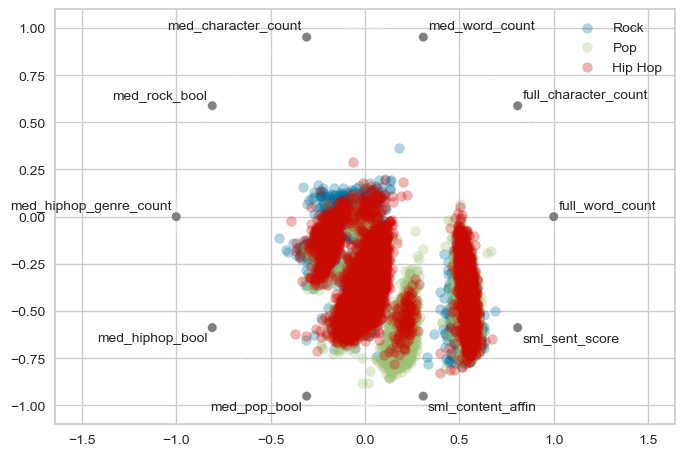

In [61]:
# Visual look at the numerical features post feature selection.

rad_viz(g4_dfd,'genre')

In [30]:
# Went from g_df (35 features) to df (25 numerical features) to n_df (25 scaled, numerical features).
#I think having both halves of [size]_word/character_count is colinearity risk. - Deleted Med, put sml in.
#I think [size]_content_affin and [size]_sent_score are meaningful.
#Dataset recommended by Pearson and my-own-biases feature selection:

g5_df = pd.DataFrame((n_df), columns=['genre','full_word_count','full_character_count',
                                      'med_rock_bool',
                                      'med_hiphop_genre_count','med_hiphop_bool',
                                      'med_pop_bool', 'sml_word_count', 'sml_character_count',
                                      'sml_content_affin','sml_sent_score'])

In [31]:
seed = 119

#Separate majority and minority classes, twice.
majority = g5_df[g5_df.genre=='Rock']
minority = g5_df[g5_df.genre=='Hip Hop']

# Downsample majority class
majority_rock_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

seed = 119

#Separate majority and minority classes, again.
majority = g5_df[g5_df.genre=='Pop']
minority = g5_df[g5_df.genre=='Hip Hop']

# Downsample majority class
majority_pop_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

# Combine minority class with downsampled majority class
g5_dfd = pd.concat([majority_rock_downsampled, majority_pop_downsampled, minority])

# Display new class counts
g5_dfd['genre'].value_counts()
# g5_dfd = 'data frame downsampled'

Rock       13560
Pop        13560
Hip Hop    13560
Name: genre, dtype: int64

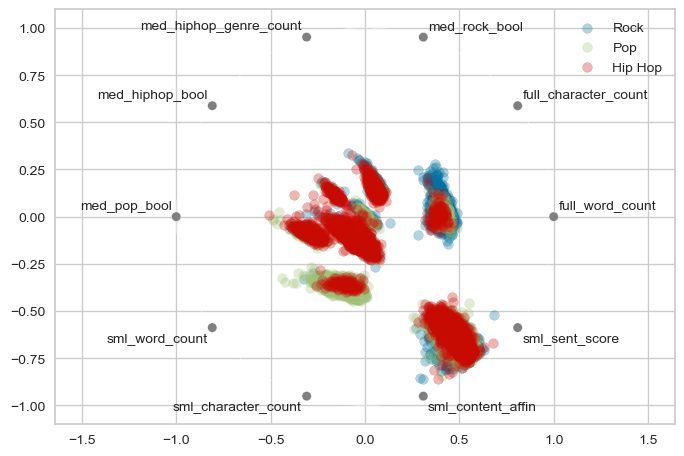

In [32]:
rad_viz(g5_dfd,'genre')

In [62]:
# Went from g_df (35 features) to df (25 numerical features) to n_df (25 scaled, numerical features).
#I think having both halves of [size]_word/character_count is colinearity risk.
#Deleted med_hiphop_genre_count
#I think [size]_content_affin and [size]_sent_score are meaningful.
#Dataset recommended by Pearson and my-own-biases feature selection:

g6_df = pd.DataFrame((n_df), columns=['genre','full_word_count','full_character_count',
                                      'med_rock_bool',
                                      'med_hiphop_bool',
                                      'med_pop_bool', 'sml_word_count', 'sml_character_count',
                                      'sml_content_affin','sml_sent_score'])

In [63]:
seed = 119

#Separate majority and minority classes, twice.
majority = g6_df[g6_df.genre=='Rock']
minority = g6_df[g6_df.genre=='Hip Hop']

# Downsample majority class
majority_rock_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

seed = 119

#Separate majority and minority classes, again.
majority = g6_df[g6_df.genre=='Pop']
minority = g6_df[g6_df.genre=='Hip Hop']

# Downsample majority class
majority_pop_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

# Combine minority class with downsampled majority class
g6_dfd = pd.concat([majority_rock_downsampled, majority_pop_downsampled, minority])

# Display new class counts
g6_dfd['genre'].value_counts()
# g6_dfd = 'data frame downsampled'

Rock       13560
Pop        13560
Hip Hop    13560
Name: genre, dtype: int64

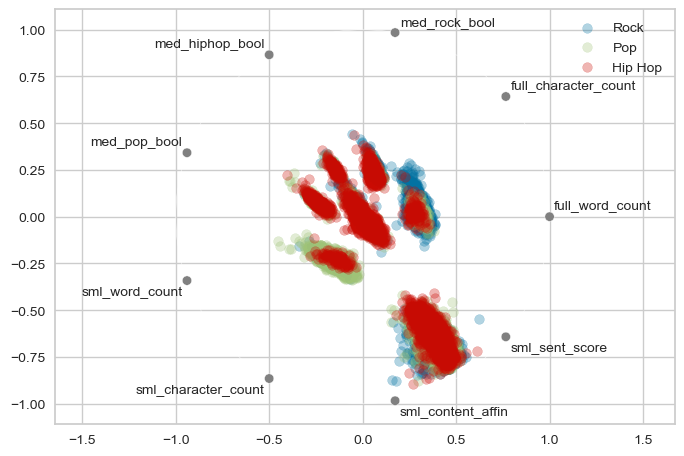

In [64]:
rad_viz(g6_dfd,'genre')

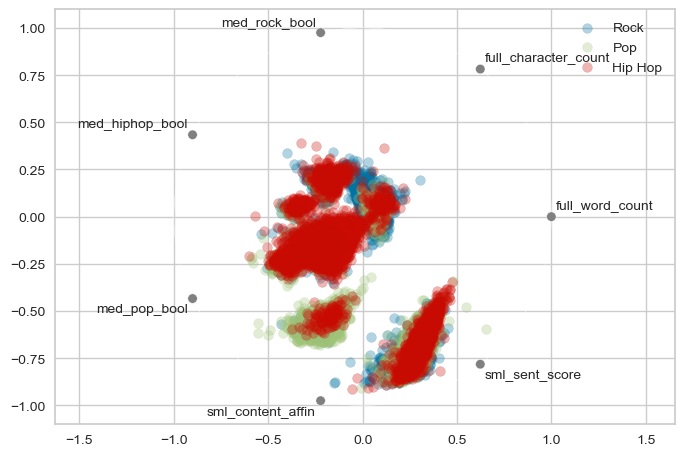

In [65]:
# Went from g_df (35 features) to df (25 numerical features) to n_df (25 scaled, numerical features).
#I think having both halves of [size]_word/character_count is colinearity risk.
#Deleted med_hiphop_genre_count, sml_word/character_count
#I think [size]_content_affin and [size]_sent_score are meaningful.
#Dataset recommended by Pearson and my-own-biases feature selection:

g7_df = pd.DataFrame((n_df), columns=['genre','full_word_count','full_character_count',
                                      'med_rock_bool',
                                      'med_hiphop_bool',
                                      'med_pop_bool',
                                      'sml_content_affin','sml_sent_score'])

seed = 119

#Separate majority and minority classes, twice.
majority = g7_df[g7_df.genre=='Rock']
minority = g7_df[g7_df.genre=='Hip Hop']

# Downsample majority class
majority_rock_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

seed = 119

#Separate majority and minority classes, again.
majority = g7_df[g7_df.genre=='Pop']
minority = g7_df[g7_df.genre=='Hip Hop']

# Downsample majority class
majority_pop_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

# Combine minority class with downsampled majority class
g7_dfd = pd.concat([majority_rock_downsampled, majority_pop_downsampled, minority])

# Display new class counts
g7_dfd['genre'].value_counts()
# g7_dfd = 'data frame downsampled'

rad_viz(g7_dfd,'genre')

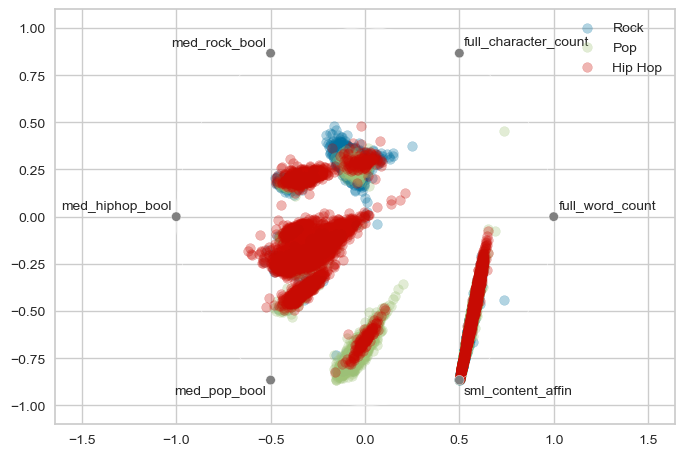

In [66]:
# Went from g_df (35 features) to df (25 numerical features) to n_df (25 scaled, numerical features).
#I think having both halves of [size]_word/character_count is colinearity risk.
#Deleted med_hiphop_genre_count, sml_word/character_count
#Trying to see if affin and or sent works well alone. Drop sent here.
#I think [size]_content_affin and [size]_sent_score are meaningful.
#Dataset recommended by Pearson and my-own-biases feature selection:

g75_df = pd.DataFrame((n_df), columns=['genre','full_word_count','full_character_count',
                                      'med_rock_bool',
                                      'med_hiphop_bool',
                                      'med_pop_bool',
                                      'sml_content_affin'])

seed = 119

#Separate majority and minority classes, twice.
majority = g75_df[g75_df.genre=='Rock']
minority = g75_df[g75_df.genre=='Hip Hop']

# Downsample majority class
majority_rock_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

seed = 119

#Separate majority and minority classes, again.
majority = g75_df[g75_df.genre=='Pop']
minority = g75_df[g75_df.genre=='Hip Hop']

# Downsample majority class
majority_pop_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

# Combine minority class with downsampled majority class
g75_dfd = pd.concat([majority_rock_downsampled, majority_pop_downsampled, minority])

# Display new class counts
g75_dfd['genre'].value_counts()
# g75_dfd = 'data frame downsampled'

rad_viz(g75_dfd,'genre')

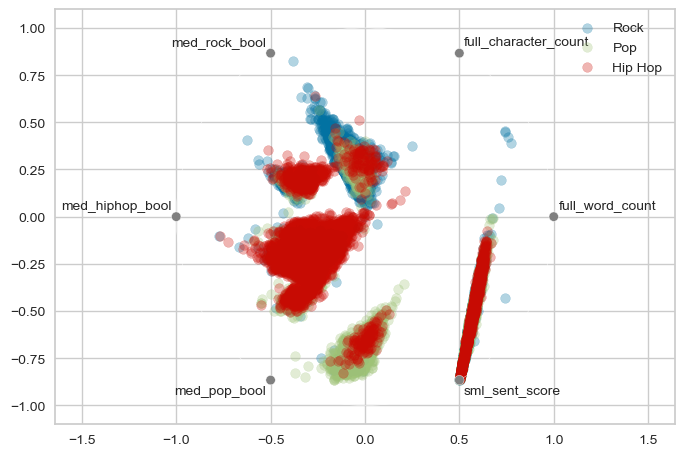

In [67]:
# Went from g_df (35 features) to df (25 numerical features) to n_df (25 scaled, numerical features).
#I think having both halves of [size]_word/character_count is colinearity risk.
#Deleted med_hiphop_genre_count, sml_word/character_count
#Trying to see if affin and or sent works well alone. Drop affin here.
#I think [size]_content_affin and [size]_sent_score are meaningful.
#Dataset recommended by Pearson and my-own-biases feature selection:

g78_df = pd.DataFrame((n_df), columns=['genre','full_word_count','full_character_count',
                                      'med_rock_bool',
                                      'med_hiphop_bool',
                                      'med_pop_bool',
                                      'sml_sent_score'])

seed = 119

#Separate majority and minority classes, twice.
majority = g78_df[g78_df.genre=='Rock']
minority = g78_df[g78_df.genre=='Hip Hop']

# Downsample majority class
majority_rock_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

seed = 119

#Separate majority and minority classes, again.
majority = g78_df[g78_df.genre=='Pop']
minority = g78_df[g78_df.genre=='Hip Hop']

# Downsample majority class
majority_pop_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

# Combine minority class with downsampled majority class
g78_dfd = pd.concat([majority_rock_downsampled, majority_pop_downsampled, minority])

# Display new class counts
g78_dfd['genre'].value_counts()
# g78_dfd = 'data frame downsampled'

rad_viz(g78_dfd,'genre')

In [42]:
# Now we're talking...

In [68]:
g2_df.genre.unique()

array(['Rock', 'Pop', 'Hip Hop'], dtype=object)

In [69]:
d_cnt_rock_df = g2_df[(g2_df['genre']=='Rock')]
d_cnt_hiphop_df = g2_df[(g2_df['genre']=='Hip Hop')]
d_cnt_pop_df = g2_df[(g2_df['genre']=='Pop')]

In [70]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='ticks',color_codes=True)

%matplotlib inline

%config InlineBackend.figure_format = 'retina'

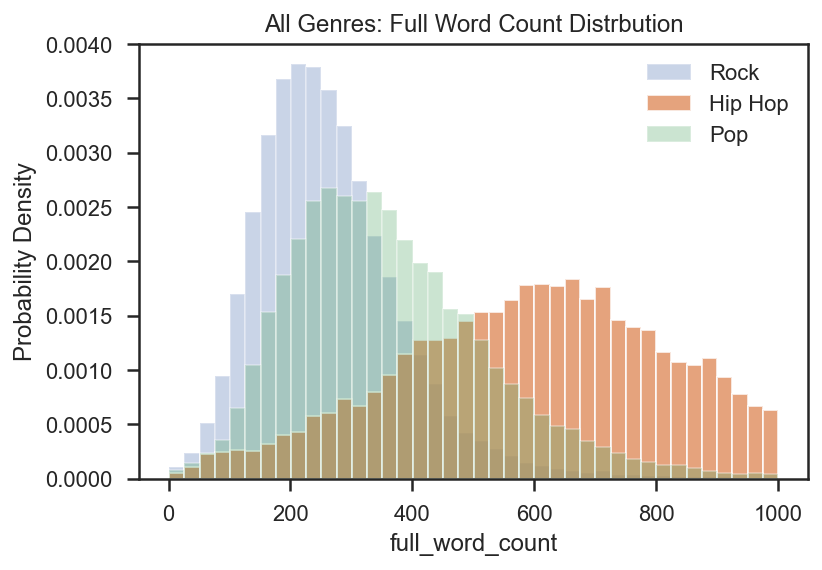

In [72]:
#Why full_word_count is useful...
plt.hist(d_cnt_rock_df['full_word_count'], bins = 40, range=(1,1000), density=True, align = 'mid', alpha = 0.3, label="Rock")
plt.hist(d_cnt_hiphop_df['full_word_count'], bins = 40, range=(1,1000), density=True, align = 'mid', alpha = 0.75,label='Hip Hop')
plt.hist(d_cnt_pop_df['full_word_count'], bins = 40, range=(1,1000), density=True, align = 'mid', alpha = 0.3, label="Pop")

plt.xlabel('full_word_count')
plt.ylabel('Probability Density')
plt.title('All Genres: Full Word Count Distrbution')
plt.legend()
plt.show()

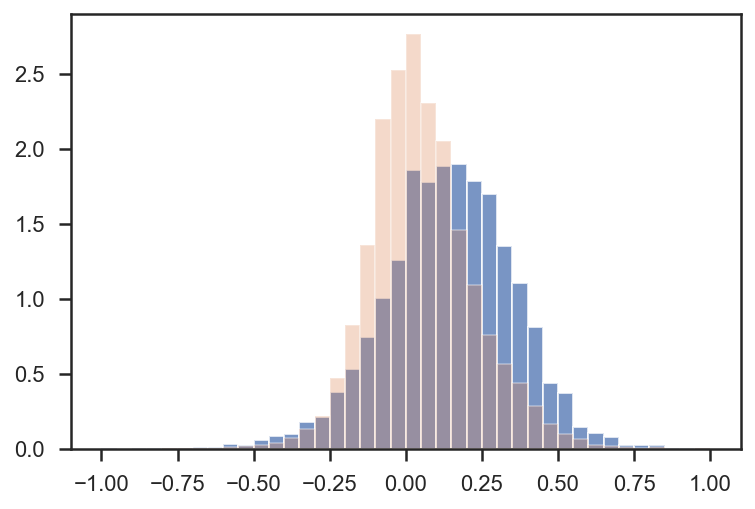

In [73]:
#Why sent_score is sorta useful.

plt.hist(d_cnt_pop_df['sml_sent_score'], bins = 40, range=(-1,1), density=True, align = 'mid', alpha = 0.75)
plt.hist(d_cnt_hiphop_df['sml_sent_score'], bins = 40, range=(-1,1), density=True, align = 'mid', alpha = 0.3)
plt.show()

The existence of keywords and the overall word count are key to breaking out the genres, in RadViz.  ANNOVA analysis is the same.  The Pearson analysis via Rank1D implied affinity and sentiment scores would be important.  But they muddy the clustering, which is likely the best way to claissify.  

I'm concerned that the lack-of-scaling of those two may have impacted this some how.  But as they are pretty uniformly disibuted between -1 and +1, naturally, that concern is probably unfounded.  

Just ran RadViz with either or sent / affin.  Doing one or the other definitely adds clarity.  sml_sent_score seems just a touch more.  So, sent label may add colinearity risk, since I'm keeping sent_score.

I will add sent label to final feature, and I can add or drop it via the pipeline ('one hot encoder' or 'drop').